Building a song recommender

In [1]:
'''------------- Dataset used: ------------- 
Million Songs Dataset Source: http://labrosa.ee.columbia.edu/millionsong/ 
Paper: http://ismir2011.ismir.net/papers/OS6-1.pdf 
The current notebook uses a subset of the above data containing 10,000 songs 
obtained from: https://github.com/turi-code/tutorials/blob/master/notebooks/recsys_rank_10K_song.ipynb'''

'------------- Dataset used: ------------- \nMillion Songs Dataset Source: http://labrosa.ee.columbia.edu/millionsong/ \nPaper: http://ismir2011.ismir.net/papers/OS6-1.pdf \nThe current notebook uses a subset of the above data containing 10,000 songs \nobtained from: https://github.com/turi-code/tutorials/blob/master/notebooks/recsys_rank_10K_song.ipynb'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import sys
sys.path.insert(0,'/content/drive/My Drive/module')

In [18]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

Load Music Data

In [7]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

Explore data
Music data shows how many times a user listened to a song, as well as the details of the song.

In [8]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


Length of dataset

In [9]:
len(song_df)

2000000

Create a subset of the dataset

In [10]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

Showing the most popular songs in the dataset

In [11]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5139,high fives - Four Tet,1,0.01
5140,in white rooms - Booka Shade,1,0.01
5143,paranoid android - Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


Count number of unique users in the dataset

In [12]:
users = song_df['user_id'].unique()
len(users)

365

Count number of unique songs in the dataset

In [13]:
songs = song_df['song'].unique()
len(songs)

5151

Create a song recommender

In [14]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id  ...                                   song
7389  94d5bdc37683950e90c56c9b32721edb5d347600  ...          Half Of My Heart - John Mayer
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  ...  The Beautiful People - Marilyn Manson
2995  15415fa2745b344bce958967c346f2a89f792f63  ...       Sanctify Yourself - Simple Minds
5316  ffadf9297a99945c0513cd87939d91d8b602936b  ...       Heart Cooks Brain - Modest Mouse
356   5a905f000fc1ff3df7ca807d57edb608863db05d  ...                Rorol - Octopus Project

[5 rows x 8 columns]


Create an instance of popularity based recommender class

In [19]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

Use the popularity model to make some predictions

In [20]:
user_id = users[5]
pm.recommend(user_id)


,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [21]:
user_id = users[8]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


Create an instance of item similarity based recommender class

In [22]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

Use the personalized model to make some song recommendations

In [23]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [24]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


We can also apply the model to find similar songs to any song in the dataset

In [25]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1
1,,Bad Company - Five Finger Death Punch,0.375000,2
2,,Love Me - Justin Bieber,0.333333,3
3,,One Time - Justin Bieber,0.333333,4
4,,Here Without You - 3 Doors Down,0.333333,5
5,,Stuck In The Moment - Justin Bieber,0.333333,6
6,,Teach Me How To Dougie - California Swag District,0.333333,7
7,,Paper Planes - M.I.A.,0.333333,8
8,,Already Gone - Kelly Clarkson,0.333333,9
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10


Use the personalized recommender model to get similar songs for the following song

In [26]:
song = 'Yellow - Coldplay'
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:37029a65b9925fb3c1964774fcab695b82955f76
No. of unique songs for the user: 26
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3922
Getting recommendations for user:baf47ed8da24d607e50d8684cde78b923538640f
No. of unique songs for the user: 84
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :10714
Getting recommendations for user:529b42cdbc379ad2e765aec6d3bad8a192038741
No. of unique songs for the user: 45
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :6764
Getting recommendations for user:9a0215ffab0f8322aeb36fa6636444b050462a51
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2109
Getting recommendations for user:6ac64072cb8f308f36c64cc4aafb6021fef70476
No. of unique songs for the user: 7
no. of unique songs in t

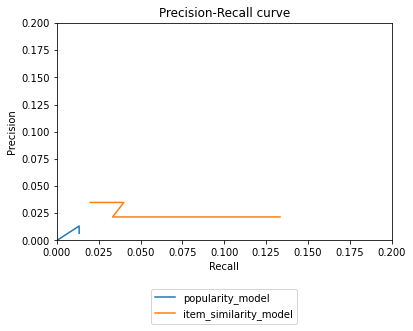

In [28]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

Matrix Factorization based Recommender System
Using SVD matrix factorization based collaborative filtering recommender system -------------------------------------------------------------------------------- The following code implements a Singular Value Decomposition (SVD) based matrix factorization collaborative filtering recommender system. The user ratings matrix used is a small matrix as follows: Item0 Item1 Item2 Item3 User0 3 1 2 3 User1 4 3 4 3 User2 3 2 1 5 User3 1 6 5 2 User4 0 0 5 0 As we can see in the above matrix, all users except user 4 rate all items. The code calculates predicted recommendations for user 4.

In [31]:
!pip install sparsesvd 

  Created wheel for sparsesvd: filename=sparsesvd-0.2.2-cp36-cp36m-linux_x86_64.whl size=296540 sha256=c85eae1ae7dae43d7087ff3b69b83f3199683ac58b47e87dcdeb0303f1bb1f2c
  Stored in directory: /root/.cache/pip/wheels/23/17/02/81e370c9cddef7ef9e5454d71bbe8be2eafa8e84c0b7b628b1
Successfully built sparsesvd


In [32]:
import math as mt
import csv
from sparsesvd import sparsesvd #used for matrix factorization
import numpy as np
from scipy.sparse import csc_matrix #used for sparse matrix
from scipy.sparse.linalg import * #used for matrix multiplication

Methods to compute SVD and recommendations

In [33]:
MAX_PID = 4
MAX_UID = 5

#Compute SVD of the user ratings matrix
def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the indices 
        #of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom

Use SVD to make predictions for a test user id, say 4

In [34]:
#Used in SVD calculation (number of latent factors)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [5, 0,0 , 0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[0 3 2 1]


Understanding Intuition behind SVD
SVD result gives three matrices as output: U, S and Vt (T in Vt means transpose). Matrix U represents user vectors and Matrix Vt represents item vectors. In simple terms, U represents users as 2 dimensional points in the latent vector space, and Vt represents items as 2 dimensional points in the same space. Next, we print the matrices U, S and Vt and try to interpret them. Think how the points for users and items will look like in a 2 dimensional axis. For example, the following code plots all user vectors from the matrix U in the 2 dimensional space. Similarly, we plot all the item vectors in the same plot from the matrix Vt.

Matrix Dimensions for U
(5, 2)


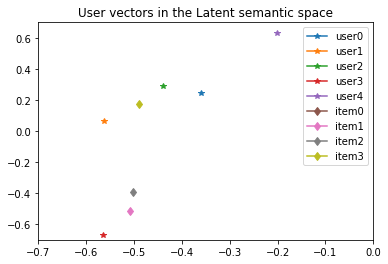

In [35]:
%matplotlib inline
from pylab import *

#Plot all the users
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()